In [1]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape, Dense, Embedding, LSTM,GRU, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:



In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy").reshape(2115)
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443, 1)


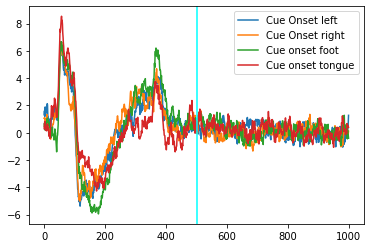

In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
def data_prep(X,y,p,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_p = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_p = p

    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.hstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.hstack((total_p, p))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y, total_p


In [6]:
## Preprocessing the dataset
X_train_valid_prep,y_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)
X_test_prep,y_test_prep,person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)
stratif_labels = []
for i in range(person_train_valid_prep.shape[0]):
    stratif_labels.append(str(person_train_valid_prep[i].astype('int'))+str(y_train_valid_prep[i]))
print(person_train_valid_prep.shape)
print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid_prep,y_train_valid_prep,test_size=1500/8460,stratify=stratif_labels)

# Creating the training and validation sets using the generated indices
# (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
# (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460,)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding

In [7]:
def cnn_model(time_period=1000):   
    time_period = min(time_period, 250)
    
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    
    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    cnn_optimizer = optimizers.Adam(learning_rate)
    
    basic_cnn_model.compile(loss='categorical_crossentropy',
                     optimizer=cnn_optimizer,
                     metrics=['accuracy'])

    # Printing the model summary
    basic_cnn_model.summary()
    
    return basic_cnn_model

In [8]:
# Model parameters
learning_rate = 1.5e-3
epochs = 50

In [9]:
def train_data(time_period=1000):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = cnn_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [10]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 1, 100)         400       
_________________________________________________________________
dropout (Dropout)            (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normalizati

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.9959 - accuracy: 0.2772 - val_loss: 2.1107 - val_accuracy: 0.2673
Epoch 2/50
6960/6960 [==============================] - 5s 706us/sample - loss: 1.7036 - accuracy: 0.2829 - val_loss: 1.6491 - val_accuracy: 0.3160
Epoch 3/50
6960/6960 [==============================] - 5s 682us/sample - loss: 1.5569 - accuracy: 0.3033 - val_loss: 1.4540 - val_accuracy: 0.3527
Epoch 4/50
6960/6960 [==============================] - 5s 780us/sample - loss: 1.4582 - accuracy: 0.3273 - val_loss: 1.3259 - val_accuracy: 0.3987
Epoch 5/50
6960/6960 [==============================] - 6s 871us/sample - loss: 1.3994 - accuracy: 0.3539 - val_loss: 1.2776 - val_accuracy: 0.4093
Epoch 6/50
6960/6960 [==============================] - 5s 656us/sample - loss: 1.3487 - accuracy: 0.3800 - val_loss: 1.2356 - val_accuracy: 0.4447
Epoch 7/50
6960/6960 [==============================] - 6s 854us/

6960/6960 [==============================] - 7s 1ms/sample - loss: 1.0959 - accuracy: 0.5250 - val_loss: 0.9927 - val_accuracy: 0.5913
Epoch 13/50
6960/6960 [==============================] - 7s 1ms/sample - loss: 1.0630 - accuracy: 0.5438 - val_loss: 0.9727 - val_accuracy: 0.5900
Epoch 14/50
6960/6960 [==============================] - 5s 739us/sample - loss: 1.0399 - accuracy: 0.5624 - val_loss: 0.9281 - val_accuracy: 0.6187
Epoch 15/50
6960/6960 [==============================] - 5s 723us/sample - loss: 1.0054 - accuracy: 0.5769 - val_loss: 0.8790 - val_accuracy: 0.6460
Epoch 16/50
6960/6960 [==============================] - 5s 652us/sample - loss: 0.9822 - accuracy: 0.5884 - val_loss: 0.8688 - val_accuracy: 0.6473
Epoch 17/50
6960/6960 [==============================] - 7s 943us/sample - loss: 0.9615 - accuracy: 0.6027 - val_loss: 0.8209 - val_accuracy: 0.6700
Epoch 18/50
6960/6960 [==============================] - 6s 845us/sample - loss: 0.9345 - accuracy: 0.6129 - val_loss: 0.7

Epoch 6/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.2120 - accuracy: 0.4636 - val_loss: 1.0882 - val_accuracy: 0.5260
Epoch 7/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.1775 - accuracy: 0.4826 - val_loss: 1.0698 - val_accuracy: 0.5300
Epoch 8/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.1321 - accuracy: 0.5056 - val_loss: 1.0504 - val_accuracy: 0.5513
Epoch 9/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.0984 - accuracy: 0.5266 - val_loss: 1.0084 - val_accuracy: 0.5600
Epoch 10/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.0505 - accuracy: 0.5582 - val_loss: 0.9707 - val_accuracy: 0.5987
Epoch 11/50
6960/6960 [==============================] - 7s 1ms/sample - loss: 1.0239 - accuracy: 0.5672 - val_loss: 0.9856 - val_accuracy: 0.5753
Epoch 12/50
6960/6960 [==============================] - 7s 1ms/sample - loss: 0.9958 - accuracy: 0.5843 - val_loss: 0.881

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 14s 2ms/sample - loss: 2.0616 - accuracy: 0.2861 - val_loss: 3.7665 - val_accuracy: 0.2953
Epoch 2/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.6354 - accuracy: 0.3282 - val_loss: 1.6271 - val_accuracy: 0.3507
Epoch 3/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.4731 - accuracy: 0.3624 - val_loss: 1.3562 - val_accuracy: 0.4240
Epoch 4/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.3195 - accuracy: 0.4158 - val_loss: 1.0981 - val_accuracy: 0.5327
Epoch 5/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.2450 - accuracy: 0.4454 - val_loss: 1.0638 - val_accuracy: 0.5513
Epoch 6/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.1753 - accuracy: 0.4849 - val_loss: 1.0183 - val_accuracy: 0.5767
Epoch 7/50
6960/6960 [==============================] - 10s 1ms/sample -

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 2.0260 - accuracy: 0.2894 - val_loss: 2.9833 - val_accuracy: 0.3433
Epoch 2/50
6960/6960 [==============================] - 12s 2ms/sample - loss: 1.6509 - accuracy: 0.3122 - val_loss: 2.2709 - val_accuracy: 0.3160
Epoch 3/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.4534 - accuracy: 0.3566 - val_loss: 1.4120 - val_accuracy: 0.4067
Epoch 4/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.3241 - accuracy: 0.4171 - val_loss: 1.1417 - val_accuracy: 0.5240
Epoch 5/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.2347 - accuracy: 0.4592 - val_loss: 1.0405 - val_accuracy: 0.5600
Epoch 6/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.1695 - accuracy: 0.4843 - val_loss: 1.0296 - val_accuracy: 0.5667
Epoch 7/50
6960/6960 [==============================] - 12s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 2.0000 - accuracy: 0.3112 - val_loss: 3.2603 - val_accuracy: 0.3287
Epoch 2/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 1.5793 - accuracy: 0.3572 - val_loss: 2.2218 - val_accuracy: 0.3620
Epoch 3/50
6960/6960 [==============================] - 14s 2ms/sample - loss: 1.3679 - accuracy: 0.4167 - val_loss: 1.3398 - val_accuracy: 0.4847
Epoch 4/50
6960/6960 [==============================] - 14s 2ms/sample - loss: 1.2303 - accuracy: 0.4807 - val_loss: 1.0763 - val_accuracy: 0.5720
Epoch 5/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.1204 - accuracy: 0.5266 - val_loss: 0.9298 - val_accuracy: 0.6167
Epoch 6/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 1.0625 - accuracy: 0.5580 - val_loss: 0.8894 - val_accuracy: 0.6347
Epoch 7/50
6960/6960 [==============================] - 14s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.9839 - accuracy: 0.3030 - val_loss: 3.4281 - val_accuracy: 0.3240
Epoch 2/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.6158 - accuracy: 0.3339 - val_loss: 1.9090 - val_accuracy: 0.3907
Epoch 3/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.3876 - accuracy: 0.3981 - val_loss: 1.2049 - val_accuracy: 0.4927
Epoch 4/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.2553 - accuracy: 0.4526 - val_loss: 1.0441 - val_accuracy: 0.5840
Epoch 5/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.1502 - accuracy: 0.5106 - val_loss: 1.0098 - val_accuracy: 0.5947
Epoch 6/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.0792 - accuracy: 0.5486 - val_loss: 0.9299 - val_accuracy: 0.6247
Epoch 7/50
6960/6960 [==============================] - 14s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.9793 - accuracy: 0.3200 - val_loss: 2.7724 - val_accuracy: 0.3407
Epoch 2/50
6960/6960 [==============================] - 16s 2ms/sample - loss: 1.5708 - accuracy: 0.3547 - val_loss: 2.6122 - val_accuracy: 0.3460
Epoch 3/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.3710 - accuracy: 0.4152 - val_loss: 1.2282 - val_accuracy: 0.5047
Epoch 4/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.2151 - accuracy: 0.4805 - val_loss: 1.0370 - val_accuracy: 0.5787
Epoch 5/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.1295 - accuracy: 0.5220 - val_loss: 1.0960 - val_accuracy: 0.5647
Epoch 6/50
6960/6960 [==============================] - 16s 2ms/sample - loss: 1.0479 - accuracy: 0.5682 - val_loss: 0.8959 - val_accuracy: 0.6460
Epoch 7/50
6960/6960 [==============================] - 13s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 2.0165 - accuracy: 0.3060 - val_loss: 3.4374 - val_accuracy: 0.3740
Epoch 2/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.5668 - accuracy: 0.3575 - val_loss: 1.8215 - val_accuracy: 0.4120
Epoch 3/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.3268 - accuracy: 0.4385 - val_loss: 1.1579 - val_accuracy: 0.5513
Epoch 4/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.1882 - accuracy: 0.4924 - val_loss: 0.9578 - val_accuracy: 0.6247
Epoch 5/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.0844 - accuracy: 0.5467 - val_loss: 0.9451 - val_accuracy: 0.6200
Epoch 6/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.0228 - accuracy: 0.5730 - val_loss: 0.8801 - val_accuracy: 0.6640
Epoch 7/50
6960/6960 [==============================] - 16s 2ms/sample

Train accuracies: 
[0.9159483, 0.97945404, 0.99109197, 0.99655175, 0.9994253, 0.9992816, 0.99971265, 0.9994253, 0.99770117, 0.9998563]
Test accuracies: 
[0.40632054, 0.5462754, 0.58690745, 0.6286682, 0.69977427, 0.7268623, 0.6788939, 0.70654625, 0.6918736, 0.7071106]


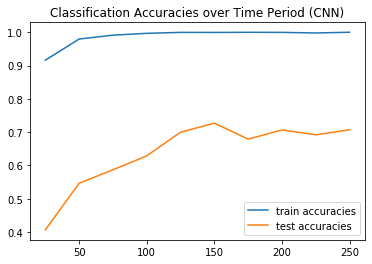

In [11]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()

In [12]:
def hybrid_model(time_period=250):   
    
    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 4
    #hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    #hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    #hybrid_cnn_lstm_model.add(BatchNormalization())
    #hybrid_cnn_lstm_model.add(Dropout(0.5))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

    hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.5, recurrent_dropout=0.1, return_sequences=False))
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=hybrid_cnn_lstm_optimizer, metrics=['accuracy'])

    # Printing the model summary
    hybrid_cnn_lstm_model.summary()
    
    return hybrid_cnn_lstm_model

In [13]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = optimizers.Adam(lr=learning_rate)

In [14]:
def hybrid_train_data(time_period=250):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = hybrid_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [15]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = hybrid_train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 9, 1, 100)         400       
_________________________________________________________________
dropout_40 (Dropout)         (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normaliz

6960/6960 [==============================] - 40s 6ms/sample - loss: 0.8855 - accuracy: 0.6305 - val_loss: 0.8175 - val_accuracy: 0.7080
Epoch 38/50
6960/6960 [==============================] - 38s 5ms/sample - loss: 0.8873 - accuracy: 0.6293 - val_loss: 0.8032 - val_accuracy: 0.7120
Epoch 39/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.8809 - accuracy: 0.6336 - val_loss: 0.7714 - val_accuracy: 0.7140
Epoch 40/50
6960/6960 [==============================] - 31s 4ms/sample - loss: 0.8646 - accuracy: 0.6447 - val_loss: 0.7618 - val_accuracy: 0.7327
Epoch 41/50
6960/6960 [==============================] - 36s 5ms/sample - loss: 0.8581 - accuracy: 0.6529 - val_loss: 0.7289 - val_accuracy: 0.7400
Epoch 42/50
6960/6960 [==============================] - 36s 5ms/sample - loss: 0.8507 - accuracy: 0.6438 - val_loss: 0.7450 - val_accuracy: 0.7280
Epoch 43/50
6960/6960 [==============================] - 36s 5ms/sample - loss: 0.8401 - accuracy: 0.6506 - val_loss: 0.7178

Epoch 22/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.8755 - accuracy: 0.6231 - val_loss: 0.7528 - val_accuracy: 0.7320
Epoch 23/50
6960/6960 [==============================] - 42s 6ms/sample - loss: 0.8505 - accuracy: 0.6434 - val_loss: 0.7254 - val_accuracy: 0.7320
Epoch 24/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.8229 - accuracy: 0.6539 - val_loss: 0.7249 - val_accuracy: 0.7307
Epoch 25/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 0.8076 - accuracy: 0.6615 - val_loss: 0.6851 - val_accuracy: 0.7567
Epoch 26/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.8090 - accuracy: 0.6580 - val_loss: 0.6879 - val_accuracy: 0.7480
Epoch 27/50
6960/6960 [==============================] - 39s 6ms/sample - loss: 0.7826 - accuracy: 0.6701 - val_loss: 0.6247 - val_accuracy: 0.7833
Epoch 28/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.7661 - accuracy: 0.6858 - val_

Epoch 7/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.1851 - accuracy: 0.4670 - val_loss: 1.1547 - val_accuracy: 0.5027
Epoch 8/50
6960/6960 [==============================] - 48s 7ms/sample - loss: 1.1474 - accuracy: 0.4921 - val_loss: 1.1418 - val_accuracy: 0.4900
Epoch 9/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.1130 - accuracy: 0.5057 - val_loss: 1.0443 - val_accuracy: 0.5413
Epoch 10/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.0952 - accuracy: 0.5147 - val_loss: 1.0043 - val_accuracy: 0.5607
Epoch 11/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.0684 - accuracy: 0.5200 - val_loss: 1.0120 - val_accuracy: 0.5647
Epoch 12/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.0376 - accuracy: 0.5467 - val_loss: 0.9457 - val_accuracy: 0.6087
Epoch 13/50
6960/6960 [==============================] - 48s 7ms/sample - loss: 1.0051 - accuracy: 0.5566 - val_los

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 69s 10ms/sample - loss: 1.3913 - accuracy: 0.2845 - val_loss: 1.4118 - val_accuracy: 0.2573
Epoch 2/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.3601 - accuracy: 0.3295 - val_loss: 1.3807 - val_accuracy: 0.2840
Epoch 3/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.3040 - accuracy: 0.3876 - val_loss: 1.2915 - val_accuracy: 0.4093
Epoch 4/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.2464 - accuracy: 0.4237 - val_loss: 1.2799 - val_accuracy: 0.4147
Epoch 5/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.2042 - accuracy: 0.4532 - val_loss: 1.2642 - val_accuracy: 0.4040
Epoch 6/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.1728 - accuracy: 0.4628 - val_loss: 1.1165 - val_accuracy: 0.5040
Epoch 7/50
6960/6960 [==============================] - 51s 7ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 66s 9ms/sample - loss: 1.3905 - accuracy: 0.2767 - val_loss: 1.3787 - val_accuracy: 0.2587
Epoch 2/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.3534 - accuracy: 0.3352 - val_loss: 1.3999 - val_accuracy: 0.3073
Epoch 3/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.2836 - accuracy: 0.4036 - val_loss: 1.3072 - val_accuracy: 0.3933
Epoch 4/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.2249 - accuracy: 0.4420 - val_loss: 1.3912 - val_accuracy: 0.4100
Epoch 5/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.1727 - accuracy: 0.4659 - val_loss: 1.2329 - val_accuracy: 0.4447
Epoch 6/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.1411 - accuracy: 0.4878 - val_loss: 1.0928 - val_accuracy: 0.5227
Epoch 7/50
6960/6960 [==============================] - 53s 8ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 75s 11ms/sample - loss: 1.3919 - accuracy: 0.2700 - val_loss: 1.3861 - val_accuracy: 0.2453
Epoch 2/50
6960/6960 [==============================] - 60s 9ms/sample - loss: 1.3481 - accuracy: 0.3329 - val_loss: 1.3874 - val_accuracy: 0.3267
Epoch 3/50
6960/6960 [==============================] - 59s 8ms/sample - loss: 1.2956 - accuracy: 0.3977 - val_loss: 1.3425 - val_accuracy: 0.3927
Epoch 4/50
6960/6960 [==============================] - 60s 9ms/sample - loss: 1.2430 - accuracy: 0.4394 - val_loss: 1.2361 - val_accuracy: 0.4367
Epoch 5/50
6960/6960 [==============================] - 59s 8ms/sample - loss: 1.1726 - accuracy: 0.4777 - val_loss: 1.1619 - val_accuracy: 0.4873
Epoch 6/50
6960/6960 [==============================] - 59s 8ms/sample - loss: 1.1199 - accuracy: 0.5065 - val_loss: 1.0278 - val_accuracy: 0.5647
Epoch 7/50
6960/6960 [==============================] - 58s 8ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 78s 11ms/sample - loss: 1.3947 - accuracy: 0.2642 - val_loss: 1.3709 - val_accuracy: 0.3073
Epoch 2/50
6960/6960 [==============================] - 63s 9ms/sample - loss: 1.3514 - accuracy: 0.3346 - val_loss: 1.3473 - val_accuracy: 0.3480
Epoch 3/50
6960/6960 [==============================] - 62s 9ms/sample - loss: 1.2928 - accuracy: 0.3858 - val_loss: 1.2930 - val_accuracy: 0.3807
Epoch 4/50
6960/6960 [==============================] - 63s 9ms/sample - loss: 1.2453 - accuracy: 0.4217 - val_loss: 1.2332 - val_accuracy: 0.4420
Epoch 5/50
6960/6960 [==============================] - 62s 9ms/sample - loss: 1.1824 - accuracy: 0.4655 - val_loss: 1.1320 - val_accuracy: 0.4987
Epoch 6/50
6960/6960 [==============================] - 61s 9ms/sample - loss: 1.1246 - accuracy: 0.4922 - val_loss: 1.1195 - val_accuracy: 0.5013
Epoch 7/50
6960/6960 [==============================] - 61s 9ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 124s 18ms/sample - loss: 1.3758 - accuracy: 0.2973 - val_loss: 1.3658 - val_accuracy: 0.3187
Epoch 2/50
6960/6960 [==============================] - 77s 11ms/sample - loss: 1.2966 - accuracy: 0.3859 - val_loss: 1.3641 - val_accuracy: 0.3553
Epoch 3/50
6960/6960 [==============================] - 79s 11ms/sample - loss: 1.2470 - accuracy: 0.4154 - val_loss: 1.3191 - val_accuracy: 0.4180
Epoch 4/50
6960/6960 [==============================] - 76s 11ms/sample - loss: 1.1865 - accuracy: 0.4540 - val_loss: 1.2006 - val_accuracy: 0.4507
Epoch 5/50
6960/6960 [==============================] - 79s 11ms/sample - loss: 1.1255 - accuracy: 0.4904 - val_loss: 1.0641 - val_accuracy: 0.5293
Epoch 6/50
6960/6960 [==============================] - 79s 11ms/sample - loss: 1.0709 - accuracy: 0.5152 - val_loss: 1.0167 - val_accuracy: 0.5633
Epoch 7/50
6960/6960 [==============================] - 79s 11m

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 132s 19ms/sample - loss: 1.3833 - accuracy: 0.2861 - val_loss: 1.3927 - val_accuracy: 0.2940
Epoch 2/50
6960/6960 [==============================] - 86s 12ms/sample - loss: 1.2991 - accuracy: 0.3826 - val_loss: 1.2926 - val_accuracy: 0.3940
Epoch 3/50
6960/6960 [==============================] - 87s 13ms/sample - loss: 1.2132 - accuracy: 0.4434 - val_loss: 1.1964 - val_accuracy: 0.4740
Epoch 4/50
6960/6960 [==============================] - 87s 13ms/sample - loss: 1.1561 - accuracy: 0.4761 - val_loss: 1.3808 - val_accuracy: 0.4413
Epoch 5/50
6960/6960 [==============================] - 86s 12ms/sample - loss: 1.1015 - accuracy: 0.5112 - val_loss: 1.0702 - val_accuracy: 0.5267
Epoch 6/50
6960/6960 [==============================] - 89s 13ms/sample - loss: 1.0610 - accuracy: 0.5237 - val_loss: 1.0264 - val_accuracy: 0.5547
Epoch 7/50
6960/6960 [==============================] - 87s 12m

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 144s 21ms/sample - loss: 1.3818 - accuracy: 0.2889 - val_loss: 1.3579 - val_accuracy: 0.3147
Epoch 2/50
6960/6960 [==============================] - 96s 14ms/sample - loss: 1.2980 - accuracy: 0.3826 - val_loss: 1.2983 - val_accuracy: 0.4187
Epoch 3/50
6960/6960 [==============================] - 92s 13ms/sample - loss: 1.2045 - accuracy: 0.4326 - val_loss: 1.2408 - val_accuracy: 0.4440
Epoch 4/50
6960/6960 [==============================] - 97s 14ms/sample - loss: 1.1434 - accuracy: 0.4761 - val_loss: 1.1618 - val_accuracy: 0.4987
Epoch 5/50
6960/6960 [==============================] - 96s 14ms/sample - loss: 1.0984 - accuracy: 0.5030 - val_loss: 1.1551 - val_accuracy: 0.5047
Epoch 6/50
6960/6960 [==============================] - 99s 14ms/sample - loss: 1.0457 - accuracy: 0.5250 - val_loss: 0.9999 - val_accuracy: 0.5413
Epoch 7/50
6960/6960 [==============================] - 99s 14m

Train accuracies: 
[0.9094828, 0.9655172, 0.98333335, 0.9863506, 0.992385, 0.9987069, 0.99813217, 0.9966954, 0.995977, 0.99626434]
Test accuracies: 
[0.4136569, 0.5112867, 0.54063207, 0.5965011, 0.62979686, 0.6580135, 0.66591424, 0.6478555, 0.6472912, 0.6580135]


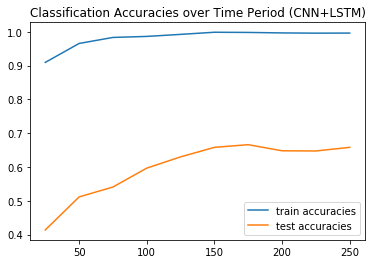

In [16]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN+LSTM)")
plt.show()